# Recap on Decision Trees

```
Authors: Alexandre Gramfort
         Thomas Moreau
```

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Decision trees encode a series of "if" and "else" choices, similar to how a person might makes a decision.
However, which questions to ask, and how to proceed for each answer is entirely learned from the data.

For example, if you wanted to create a guide to identifying an animal found in nature, you
might ask the following series of questions:

- Is the animal **bigger or smaller than a meter long**?
    + *bigger*: does the animal **have horns**?
        - *yes*: are the horns longer than ten centimeters?
        - *no*: is the animal wearing a collar
    + *smaller*: does the animal **have two or four legs**?
        - *two*: does the animal have wings?
        - *four*: does the animal have a bushy tail?

and so on.  This binary splitting of questions is the essence of a decision tree.

One of the main **benefit of tree-based models** is that they require **little preprocessing of the data**.
They can work with **variables of different types** (continuous and categorical) and are **invariant to scaling of the features**.

Another benefit is that tree-based models are what is called **"nonparametric"**, which means they don't have a fix set of parameters to learn. Instead, **a tree model can become more and more flexible**, if given more data.
In other words, the **number of free parameters grows with the number of samples** and is not fixed, as for example in linear models.

## Decision Tree Classification

### Generate a simple dataset

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(
    centers=[[0, 0], [1, 1]], random_state=61526, n_samples=100
)

First, let's look at the generated data

In [3]:
classes = np.unique(y)
print(f"The class labels are: {classes}")

The class labels are: [0 1]


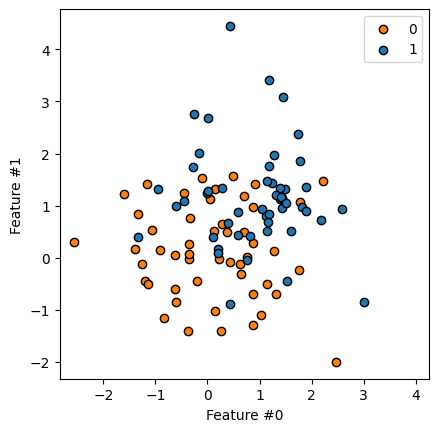

In [4]:
_, ax = plt.subplots()
for klazz, color in zip(classes, ["tab:orange", "tab:blue"]):
    mask_sample_klazz = y == klazz
    ax.scatter(
        X[mask_sample_klazz, 0], X[mask_sample_klazz, 1],
        color=color, label=klazz,
        edgecolor="black",
    )
plt.axis("square")
plt.legend()
plt.xlabel("Feature #0")
_ = plt.ylabel("Feature #1")

We will create a function to create this scatter plot by passing 2 variables: `data` and `labels`.

In [5]:
def plot_data(data, labels, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    classes = np.unique(labels)
    for klazz, color in zip(classes, ["tab:orange", "tab:blue"]):
        mask_sample_klazz = labels == klazz
        ax.scatter(
            data[mask_sample_klazz, 0], data[mask_sample_klazz, 1],
            color=color, label=klazz,
            edgecolor="black",
        )
    sns.despine()
    ax.axis("square")
    plt.legend()
    plt.xlabel("Feature #0")
    _ = plt.ylabel("Feature #1")
    return ax

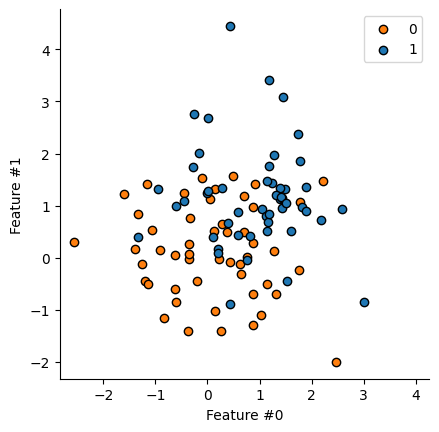

In [6]:
_ = plot_data(X, y)

### Train a decision tree classifier

We can learn a set of binary rule using a portion of the data. Using the rules learned, we will predict on the testing data.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

In [16]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=1)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1])

We can plot the decision boundaries found using the training data.

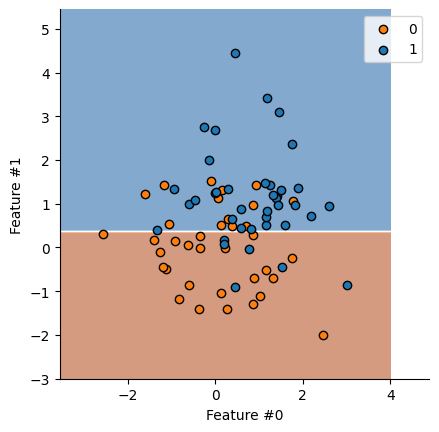

In [17]:
from figures import DecisionBoundaryDisplay

display = DecisionBoundaryDisplay.from_estimator(
    clf, X, alpha=0.5
)
_ = plot_data(X_train, y_train, ax=display.ax_)

Similarly, we get the following classification on the testing set.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
     <li>Modify the depth of the tree and see how the partitioning evolves. </li>
     </ul>
</div>

In the interactive plot below, the regions are assigned blue and orange colors to indicate the predicted class for that region. The shade of the color indicates the predicted probability for that class (darker = higher probability), while white regions indicate an equal predicted probability for either class.

In [18]:
from figures import plot_tree_interactive
plot_tree_interactive()

interactive(children=(IntSlider(value=0, description='max_depth', max=8), Output()), _dom_classes=('widget-int…

### Learning rule for splitting in decision tree for binary classification

In this section, we will go slightly more into details regarding how a tree is selecting the best partition. First, instead of using synthetic data, we will use a real dataset this time.

In [19]:
dataset = pd.read_csv("datasets/penguins.csv")
dataset = dataset.dropna(subset=["Body Mass (g)"])
dataset.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN
5,PAL0708,6,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A2,Yes,2007-11-16,39.3,20.6,190.0,3650.0,MALE,8.66496,-25.29805,NaN


We will build a decision tree to classify the penguin species using their body mass as a feature. To simplify the problem will focus only the Adelie and Gentoo species.

In [20]:
# Only select the column of interest
dataset = dataset[["Body Mass (g)", "Species"]]
# Make the species name more readable
dataset["Species"] = dataset["Species"].apply(lambda x: x.split()[0])
# Only select the Adelie and Gentoo penguins
dataset = dataset.set_index("Species").loc[["Adelie", "Gentoo"], :]
# Sort all penguins by their body mass
dataset = dataset.sort_values(by="Body Mass (g)")
# Convert the dataframe (2D) to a series (1D)
dataset = dataset.squeeze()
dataset

Species
Adelie    2850.0
Adelie    2850.0
Adelie    2900.0
Adelie    2900.0
Adelie    2900.0
           ...  
Gentoo    5950.0
Gentoo    6000.0
Gentoo    6000.0
Gentoo    6050.0
Gentoo    6300.0
Name: Body Mass (g), Length: 274, dtype: float64

We will first look at the body mass distribution for each specie.

Text(0, 0.5, 'Probability')

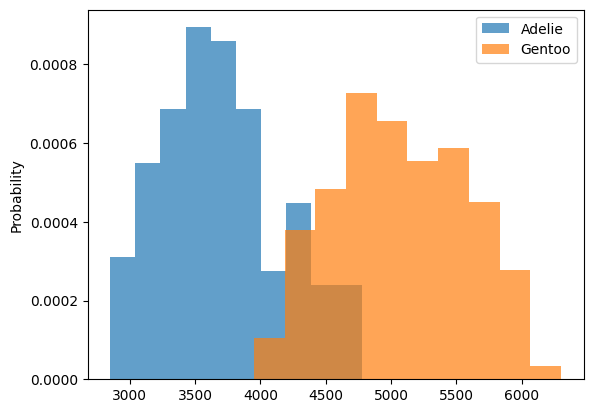

In [21]:
_, ax = plt.subplots()
dataset.groupby("Species").plot.hist(ax=ax, alpha=0.7, legend=True, density=True)
ax.set_ylabel("Probability")

Instead to look at the distribution, we can look at all samples directly.

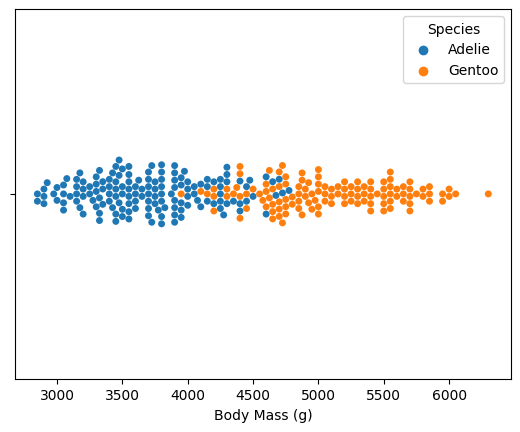

In [22]:
ax = sns.swarmplot(x=dataset.values, y=[""] * len(dataset),
                   hue=dataset.index)
_ = ax.set_xlabel(dataset.name)

When we build a tree, we want to find splits, one at the time, such that we partition the data in way that classes as "unmixed" as possible. Let's make a first completely random split to highlight the principle.

In [23]:
# create a random state such we all have the same results
rng = np.random.RandomState(42)

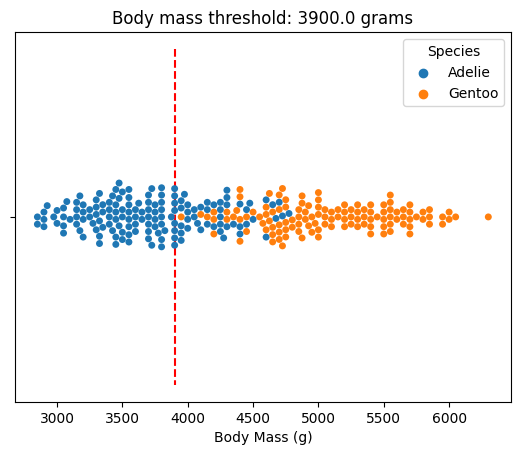

In [24]:
random_idx = rng.choice(dataset.size)

ax = sns.swarmplot(x=dataset.values, y=[""] * len(dataset),
                   hue=dataset.index)
ax.set_xlabel(dataset.name)
ax.set_title(f"Body mass threshold: {dataset[random_idx]} grams")
_ = ax.vlines(dataset[random_idx], -1, 1, color="red", linestyle="--")

Once the split done, we seek for having two partitions for which the samples are as much as possible from a single class and contains as many samples as possible. In decision tree, we used a **criterion** to assess the quality of a split. The **entropy** is one of the statistic which can describe the class mixity in a partition. Let's compute the entropy for the full dataset, the set on the left of the threshold and the set on the right of the split.

Let's first look at the entropy function:

In [25]:
from scipy.stats import entropy

In [26]:
from ipywidgets import interact

@interact(proportion=(0., 1.0))
def plot_entropy(proportion=0.5):
    ps = np.linspace(0, 1, 100)
    ents = [entropy([p, 1-p]) for p in ps]
    plt.figure(figsize=(6, 3))
    plt.plot(ps, ents)
    plt.ylabel('Entropy')
    plt.xlabel('Proportion of class 1')
    plt.axvline(proportion, linestyle='--', color='k')

interactive(children=(FloatSlider(value=0.5, description='proportion', max=1.0), Output()), _dom_classes=('wid…

As you can see the entropy is 0 when you have no mixing between classes and it's maximal when you have 50% of each class.

In [ ]:
dataset.index.value_counts(normalize=True)

In [ ]:
parent_entropy = entropy(
    dataset.index.value_counts(normalize=True)
)
parent_entropy

In [ ]:
left_entropy = entropy(
    dataset[:random_idx].index.value_counts(normalize=True)
)
left_entropy

In [ ]:
right_entropy = entropy(
    dataset[random_idx:].index.value_counts(normalize=True)
)
right_entropy

We can see the quality of the split by combining the entropies. This is known as the **information gain**.

In [ ]:
parent_entropy - (left_entropy + right_entropy)

However, we should normalize the entropies with the number of samples in each sets.

In [ ]:
def information_gain(labels_parent, labels_left, labels_right):
    # compute the entropies
    entropy_parent = entropy(labels_parent.value_counts(normalize=True))
    entropy_left = entropy(labels_left.value_counts(normalize=True))
    entropy_right = entropy(labels_right.value_counts(normalize=True))

    n_samples_parent = labels_parent.size
    n_samples_left = labels_left.size
    n_samples_right = labels_right.size

    # normalize with the number of samples
    normalized_entropy_left = ((n_samples_left / n_samples_parent) * 
                               entropy_left)
    normalized_entropy_right = ((n_samples_right / n_samples_parent) *
                                entropy_right)

    return (entropy_parent -
            normalized_entropy_left - normalized_entropy_right)

In [ ]:
information_gain(
    dataset.index,
    dataset[:random_idx].index,
    dataset[random_idx:].index
)

So, we can compute the information gain for all possible body mass thresholds.

In [ ]:
all_information_gain = pd.Series(
    [information_gain(dataset.index, dataset[:idx].index, dataset[idx:].index)
     for idx in range(dataset.size)],
    index=dataset,
)

In [ ]:
ax = all_information_gain.plot()
_ = ax.set_ylabel("Information gain")

In [ ]:
ax = (all_information_gain * -1).plot(color="red", label="Information gain")
ax = sns.swarmplot(x=dataset.values, y=[""] * len(dataset), hue=dataset.index)

We can see that the maximum of the information gain corresponds to the split which best partitions our data. So we can check the corresponding body mass threshold.

In [ ]:
all_information_gain.idxmax()

In [ ]:
ax = (all_information_gain * -1).plot(color="red", label="Information gain")
ax = sns.swarmplot(x=dataset.values, y=[""] * len(dataset), hue=dataset.index)
ax.vlines(
    all_information_gain.idxmax(), -1, 1,
    color="red", linestyle="--"
)

## Decision Tree Regression

In [ ]:
rnd = np.random.RandomState(42)
x = np.linspace(-3, 3, 100)
y_no_noise = np.sin(4 * x) + x
y = y_no_noise + rnd.normal(size=len(x))
X = x.reshape(-1, 1)

plt.figure()
plt.xlabel('Feature X')
plt.ylabel('Target y')
_ = plt.scatter(X, y)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=2)
reg.fit(X, y)

In [ ]:
X_test = np.linspace(-3, 3, 1000).reshape((-1, 1))
y_test = reg.predict(X_test)

plt.figure()
plt.plot(X_test.ravel(), y_test, color='tab:blue', label="prediction")
plt.plot(X.ravel(), y, 'C7.', label="training data")
_ = plt.legend(loc="best")

A single decision tree allows us to estimate the signal in a non-parametric way,
but clearly has some issues.  In some regions, the model shows high bias and
under-fits the data.
(seen in the long flat lines which don't follow the contours of the data),
while in other regions the model shows high variance and over-fits the data
(reflected in the narrow spikes which are influenced by noise in single points).

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
      Take the above example and repeat the training/testing by changing depth of the tree.
      </li>
    </ul>
</div>

**HINT:** You can use `from ipywidgets import interact` to make an interactive plot.

Solution is in `solutions/01-interactive_tree_regression.py`

### How about the splitting criterion for a Decision Tree for regression?

When considering a decision tree for regression and the Mean Squared Error (MSE)
as the loss the "impurity" is simply the variance of the leaf:

$$\mathrm{impurity}(l) = \mathrm{Var}(\{y_i, \forall x_i \in l\})$$

where $l$ is the leaf considered.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
         <li>
             Compute the information gain when using MSE as loss and variance as impurity criterion.
         </li>
         <li>
             Estimate the best first split for the above 1D dataset.
         </li>
         <li>
             What is the complexity of your algorithm?
         </li>
         <li>
             What would you change if you the loss is now the Mean Absolute Error (MAE)?
         </li>
    </ul>
</div>

Solution is in: `solutions/01-tree_regression_impurity.py`

You will check that you get the same values as:

In [ ]:
reg = DecisionTreeRegressor(max_depth=1)
reg.fit(X, y)
print(reg.tree_.impurity)

from sklearn.tree import plot_tree
_ = plot_tree(reg)